<a href="https://colab.research.google.com/github/neelsoumya/python_machine_learning/blob/main/pca_when_not_to_do.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

A notebook to explain when to *not* apply PCA and how to apply tSNE and when to apply hierarchical clustering and heatmaps. This explains the nuances of applying these techniques to your data.

### Where PCA can fail (with biology-flavored examples)

- **Nonlinear structure**
  - Swiss roll/curved trajectories (e.g., differentiation trajectories); PCA flattens and mixes cells that are nearby in 2D but far along the curve.
  - Concentric patterns (e.g., ring-like responses); PCA can’t separate circles.

- **When variance ≠ signal**
  - Batch effects or library size dominate variance in scRNA‑seq; PCs reflect technical factors rather than biology.
  - Cell cycle effects overshadow subtle lineage differences.
  - Rare cell types: biologically important but low variance, thus missed by top PCs.
  - XOR-like structure: classes differ along interactions, not along single linear directions.

- **Outliers and heavy tails**
  - A few extreme samples/genes drive the first PCs, masking true structure (common with QC issues or outlier libraries).

- **Feature scaling and units**
  - Mixed units or unscaled features: high-variance genes/proteins dominate; low-variance but important markers get ignored.

- **Compositional/count data**
  - Microbiome (relative abundances) or RNA-seq counts: closure and zero inflation violate PCA assumptions; raw-count PCA is misleading.

- **Multimodal mixtures**
  - Multiple clusters with different orientations/variances: a single global linear projection can blur cluster separation.

- **Time/phase structure**
  - Periodic processes (cell cycle phases): PCA captures amplitude rather than phase, mixing states.

- **p >> n instability**
  - Many more genes than samples: PCs become noisy/unstable without regularization or careful preprocessing.

- **Missing data**
  - Nonrandom missingness (dropouts in scRNA‑seq) biases covariance; naive imputation can create artificial PCs.

### Quick remedies
- Nonlinear structure: t‑SNE/UMAP, diffusion maps, PHATE, kernel PCA.
- Variance ≠ signal: regress out batch/cell cycle; use sctransform; combat/BBKNN/Harmony for batch correction; consider supervised methods (PLS/CCA) if labels exist.
- Outliers/heavy tails: robust PCA, rank genes with robust dispersion, Winsorize/log1p.
- Scaling/units: standardize features; use variance-stabilizing transforms (log1p, VST).
- Compositional data: CLR/ALR transforms; use compositional-aware methods before PCA.
- p >> n: feature selection (highly variable genes), shrinkage covariance, cross-validation for PC selection.


**Generating synthetic data**

Generate synthetic "biological" expression matrix of 200 samples × 10 genes, where Gene_1 and Gene_2 follow an XOR‐style clustering (four corner clusters) and the remaining genes are just Gaussian noise. You can see from the scatter of Gene_1 vs Gene_2 that the true structure is non-linear and not aligned with any single variance direction: PCA would fail to unfold these XOR clusters into separate principal components.

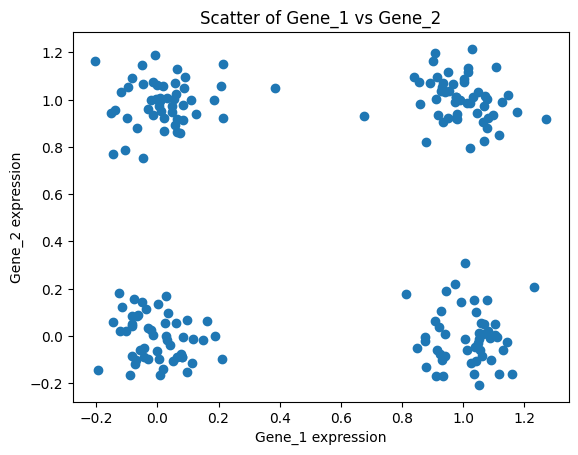

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 200
n_genes = 10

# Generate XOR structure for genes 1 and 2
gene1 = np.random.choice([0, 1], size=n_samples)
#gene2 = np.array([np.random.choice([0, 1]) if g1 == 0 else np.random.choice([0, 1]) for g1 in gene1])
gene2 = np.random.choice( [0,1], size=n_samples)
# Apply XOR: keep only points where gene1 XOR gene2 == 1 as cluster, but here keep all with label implicit
# For continuous spread, add small noise
gene1 = gene1 + 0.1 * np.random.randn(n_samples)
gene2 = gene2 + 0.1 * np.random.randn(n_samples)

# Generate remaining genes as random noise
other_genes = np.random.randn(n_samples, n_genes - 2)

# Combine into a DataFrame
data = np.hstack([gene1.reshape(-1,1), gene2.reshape(-1,1), other_genes])
genes = [f'Gene_{i+1}' for i in range(n_genes)]
df = pd.DataFrame(data, columns=genes)

# Scatter plot for Gene_1 vs Gene_2 to visualize the non-linear structure
plt.figure()
plt.scatter(df['Gene_1'], df['Gene_2'])
plt.title('Scatter of Gene_1 vs Gene_2')
plt.xlabel('Gene_1 expression')
plt.ylabel('Gene_2 expression')
plt.show()

**Use** PCA on this data

Explained variance ratio of the first two PCs:
[0.15373829 0.14237123]


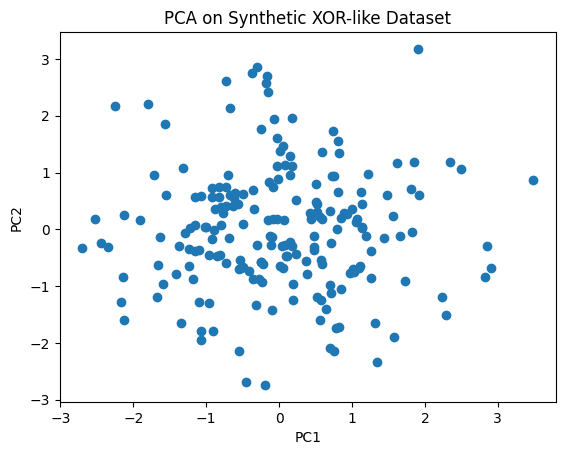

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(df)

# Print explained variance ratio
print("Explained variance ratio of the first two PCs:")
print(pca.explained_variance_ratio_)

# Scatter plot of the first two principal components
plt.figure()
plt.scatter(pcs[:, 0], pcs[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on Synthetic XOR-like Dataset')
plt.show()


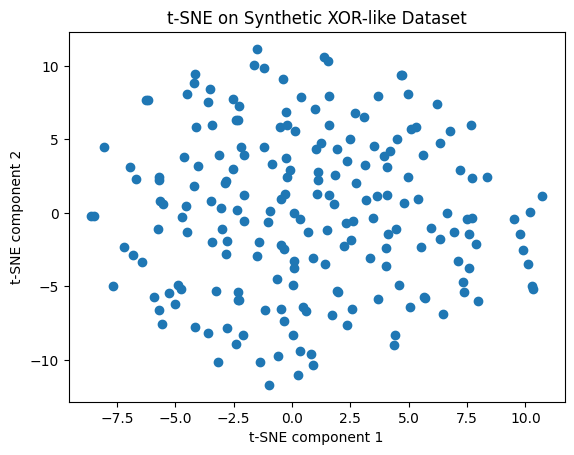

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume 'df' already exists in the workspace from the dataset generation

# Apply t-SNE
# It's often beneficial to reduce the dimensionality first with PCA before applying t-SNE
# especially for larger datasets or higher dimensions, but for this small dataset,
# we can apply t-SNE directly.
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df)

# Scatter plot of the t-SNE results
plt.figure()
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE on Synthetic XOR-like Dataset')
plt.show()

### Exploring t-SNE Perplexity

The `perplexity` parameter in t-SNE is related to the number of nearest neighbors used in the algorithm. It can have a significant impact on the resulting visualization. Let's see how different perplexity values affect the output for our synthetic dataset. The paper "How to Use t-SNE Effectively" suggests trying values between 5 and 50.

https://distill.pub/2016/misread-tsne/


Running t-SNE with perplexity=2...
Running t-SNE with perplexity=5...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=50...
Running t-SNE with perplexity=100...


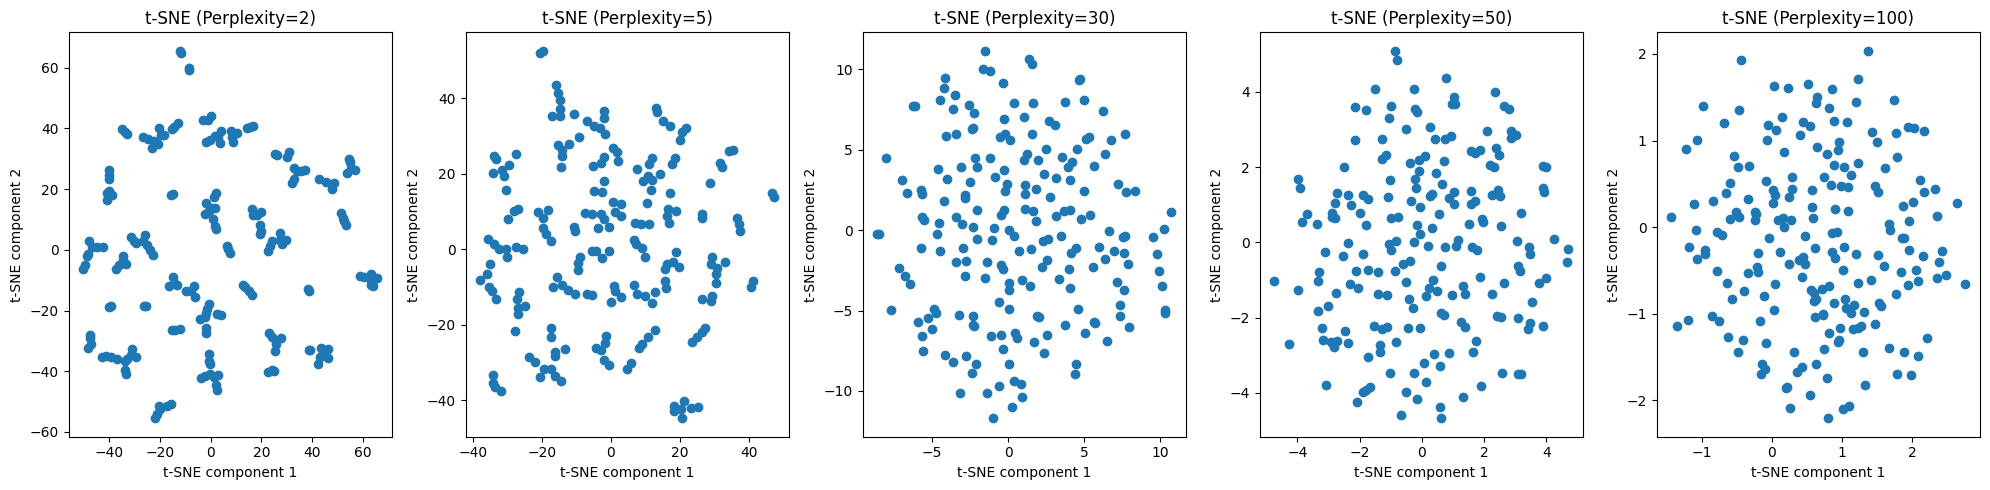

In [4]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert DataFrame to numpy array
data = df.values

# Define different perplexity values to explore
perplexities = [2, 5, 30, 50, 100] # Exploring values between 2 and 100

plt.figure(figsize=(20, 5)) # Adjust figure size for more subplots

for i, perplexity in enumerate(perplexities):
    print(f"Running t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_results = tsne.fit_transform(data)

    # Create a subplot for each perplexity value
    plt.subplot(1, len(perplexities), i + 1)
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.title(f't-SNE (Perplexity={perplexity})')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

### Kernel PCA

Let's apply Kernel PCA to the synthetic dataset. We will use a radial basis function (RBF) kernel, which is commonly used for capturing non-linear relationships.

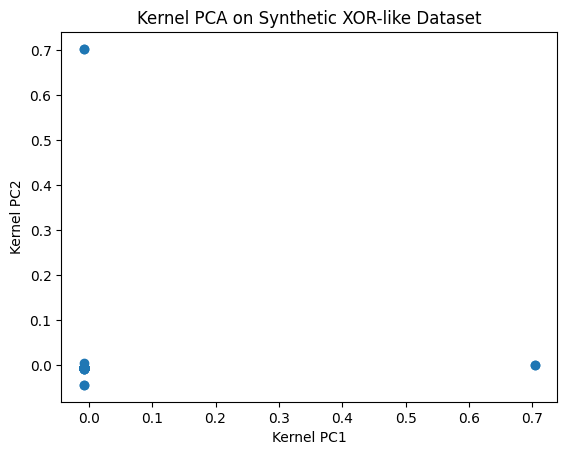

In [5]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Assume 'df' already exists in the workspace from the dataset generation

# Apply Kernel PCA with an RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10) # Gamma is a parameter for the RBF kernel
kpcs = kpca.fit_transform(df)

# Scatter plot of the first two kernel principal components
plt.figure()
plt.scatter(kpcs[:, 0], kpcs[:, 1])
plt.xlabel('Kernel PC1')
plt.ylabel('Kernel PC2')
plt.title('Kernel PCA on Synthetic XOR-like Dataset')
plt.show()

Use autoencoder on this data

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


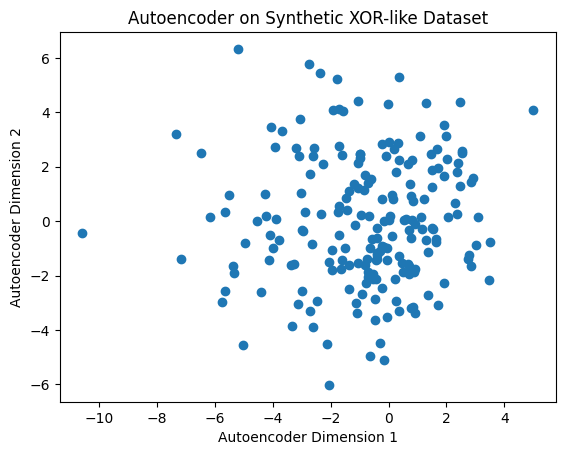

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# Convert DataFrame to numpy array
data = df.values.astype(np.float32)

# Define the Autoencoder model
input_dim = data.shape[1]
encoding_dim = 2 # We want to reduce to 2 dimensions for visualization

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder_output = Dense(encoding_dim, activation='linear')(encoder) # Linear activation for the bottleneck

# Decoder
decoder = Dense(32, activation='relu')(encoder_output)
decoder = Dense(64, activation='relu')(decoder)
decoder_output = Dense(input_dim, activation='linear')(decoder) # Linear activation for output

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder_output)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
# Use a smaller batch size and more epochs for potentially better learning of structure
history = autoencoder.fit(data, data,
                          epochs=100, # Increased epochs
                          batch_size=16, # Decreased batch size
                          shuffle=True,
                          validation_split=0.1,
                          verbose=0) # Set verbose to 0 to reduce output during training

# Create a separate encoder model to get the reduced dimensions
encoder_model = Model(inputs=input_layer, outputs=encoder_output)

# Get the reduced dimensions
encoded_data = encoder_model.predict(data)

# Scatter plot of the autoencoder's reduced dimensions
plt.figure()
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel('Autoencoder Dimension 1')
plt.ylabel('Autoencoder Dimension 2')
plt.title('Autoencoder on Synthetic XOR-like Dataset')
plt.show()

# Optional: Plot training loss
# plt.figure()
# plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
# plt.title('Autoencoder Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### Generating Synthetic Data: Multiple Gaussian Clusters

Inspired by the examples in "How to Use t-SNE Effectively", let's generate a synthetic dataset consisting of multiple distinct Gaussian clusters in a higher-dimensional space. This type of data is often used to illustrate how t-SNE can reveal clustering structure.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 300 # Increase samples to have more points per cluster
n_features = 20 # Higher dimension
n_clusters = 5 # Number of distinct clusters

# Generate data for each cluster
data_list = []
labels = []

for i in range(n_clusters):
    # Generate cluster center
    center = np.random.randn(n_features) * 5 # Spread centers out
    # Generate points around the center
    cluster_data = center + np.random.randn(n_samples // n_clusters, n_features) * 1.5 # Add some variance
    data_list.append(cluster_data)
    labels.extend([i] * (n_samples // n_clusters))

# Combine data from all clusters
data = np.vstack(data_list)
labels = np.array(labels)

# Convert to DataFrame
features = [f'Feature_{i+1}' for i in range(n_features)]
df_clusters = pd.DataFrame(data, columns=features)


# Note: Visualizing this directly in 2D is hard due to high dimensions.
# We will use dimensionality reduction techniques like t-SNE or PCA to visualize it later.
print(f"Generated dataset with shape: {df_clusters.shape}")
print(f"Generated labels with shape: {labels.shape}")

Generated dataset with shape: (300, 20)
Generated labels with shape: (300,)


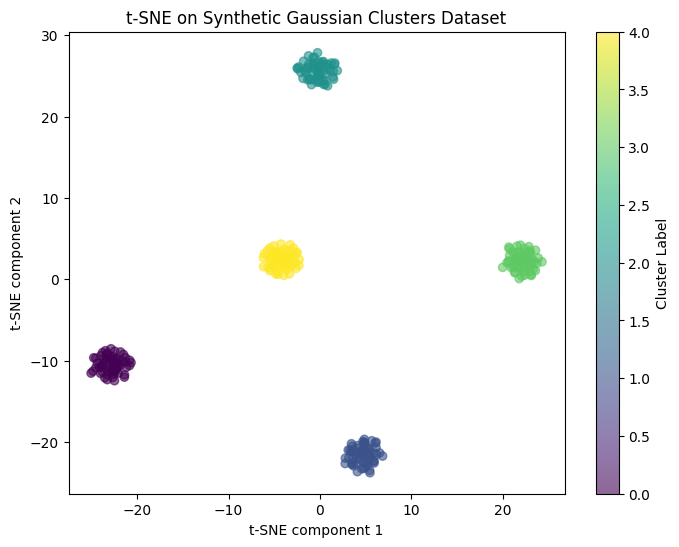

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE to the new dataset
tsne = TSNE(n_components=2, random_state=42)
tsne_results_clusters = tsne.fit_transform(df_clusters)

# Scatter plot of the t-SNE results, colored by true labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results_clusters[:, 0], tsne_results_clusters[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE on Synthetic Gaussian Clusters Dataset')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

Running t-SNE with perplexity=2...
Running t-SNE with perplexity=5...
Running t-SNE with perplexity=30...
Running t-SNE with perplexity=50...
Running t-SNE with perplexity=100...


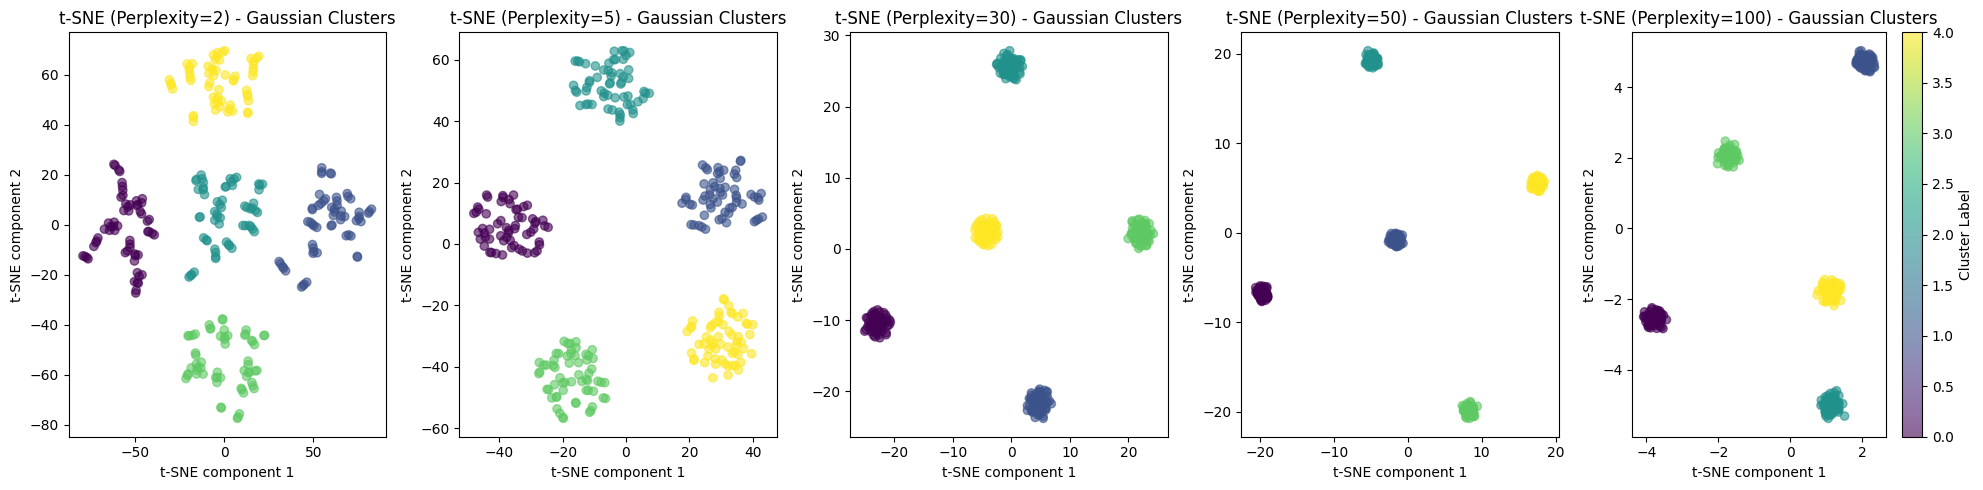

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume 'df_clusters' and 'labels' exist from the dataset generation

# Convert DataFrame to numpy array
data_clusters = df_clusters.values

# Define different perplexity values to explore
perplexities = [2, 5, 30, 50, 100] # Exploring values between 2 and 100

plt.figure(figsize=(20, 5)) # Adjust figure size for more subplots

for i, perplexity in enumerate(perplexities):
    print(f"Running t-SNE with perplexity={perplexity}...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_results_clusters = tsne.fit_transform(data_clusters)

    # Create a subplot for each perplexity value, colored by true labels
    plt.subplot(1, len(perplexities), i + 1)
    scatter = plt.scatter(tsne_results_clusters[:, 0], tsne_results_clusters[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(f't-SNE (Perplexity={perplexity}) - Gaussian Clusters')
    plt.xlabel('t-SNE component 1')
    plt.ylabel('t-SNE component 2')
    # Add colorbar to the last subplot for clarity
    if i == len(perplexities) - 1:
        plt.colorbar(scatter, label='Cluster Label')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

**Activities**

Read the paper

https://distill.pub/2016/misread-tsne/

and understand how to interpret tSNE


**Real world example**


* Example of IL10 project (tSNE and heatmaps from a bioinformatics project)

* Deconvolution of monocyte responses in inflammatory bowel disease reveals an IL-1 cytokine network that regulates IL-23 in genetic and acquired IL-10 resistance, _Gut_, 2020

* https://gut.bmj.com/content/70/6/1023

![Example tSNE ](https://gut.bmj.com/content/gutjnl/70/6/1023/F3.large.jpg)

![Example heatmaps](https://gut.bmj.com/content/gutjnl/70/6/1023/F5.large.jpg)


# Single cell data (non-linearity)

Analysis of single-cell data

In [10]:
pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 4.7 MB/s eta 0:00:00


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


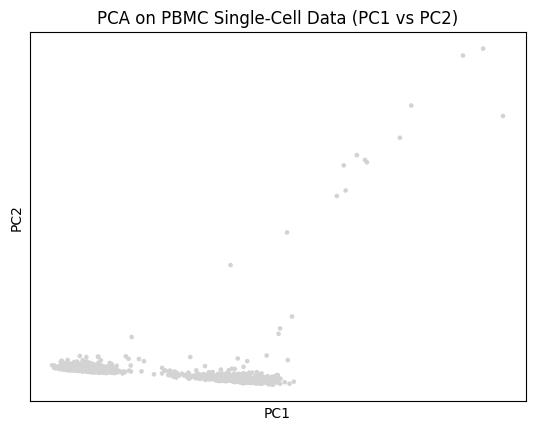

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt

# Load built-in PBMC dataset (3,000 Peripheral Blood Mononuclear Cells)
adata = sc.datasets.pbmc3k()

# Preprocess the data
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata)

# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot the first two principal components
sc.pl.pca(adata, title='PCA on PBMC Single-Cell Data (PC1 vs PC2)')

## Non-linear techniques

The data lies in a nonlinear, high-dimensional manifold shaped by diverse gene expression programs across cell types (T cells, B cells, monocytes, etc.).

PCA compresses variance linearly, and here it fails to cleanly separate cell types.

This makes a strong case for nonlinear methods like UMAP or t-SNE.

## Perform tSNE on single-cell data

In [12]:
pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 32.6 MB/s eta 0:00:00


In [13]:
pip install louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for louvain: filename=louvain-0.8.2-cp312-cp312-linux_x86_64.whl size=971850 sha256=93f8cd24813209e015c136bbcdd1c69935fb1e6616dd754c8859e5adc66136fc
  Stored in directory: /root/.cache/pip/wheels/40/de/2b/bb7ed19d84727f9f299f20cd34c42bba9c8bef7d83d2255c86
Successfully built louvain


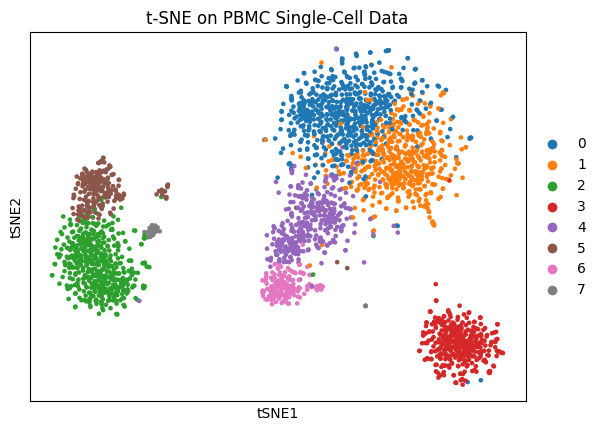

In [14]:
# Run t-SNE
sc.tl.tsne(adata, n_pcs=50, random_state=42)

# Compute nearest neighbors
sc.pp.neighbors(adata, n_pcs=50)

# Perform Louvain clustering
sc.tl.louvain(adata)

# Plot the t-SNE results
sc.pl.tsne(adata, color='louvain', title='t-SNE on PBMC Single-Cell Data')

## What if data has categorical features?

PCA may not work if you have categorical features

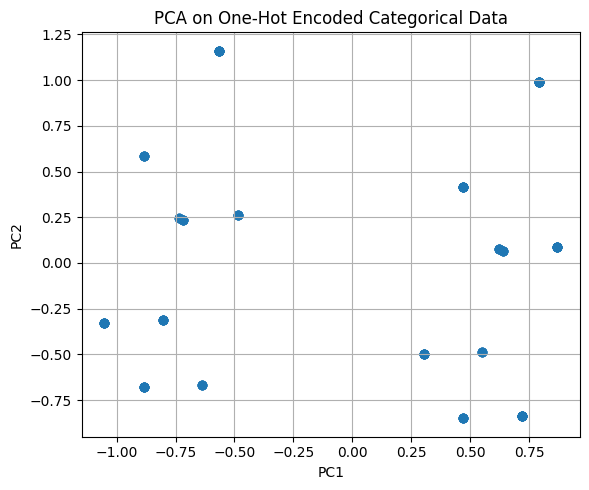

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Generate synthetic data with categorical features
np.random.seed(42)
n_samples = 200

# Categorical features
species = np.random.choice(['mouse', 'rat', 'human'], size=n_samples)
tissue = np.random.choice(['liver', 'brain', 'heart'], size=n_samples)
condition = np.random.choice(['healthy', 'diseased'], size=n_samples)

# Create DataFrame
df_cat = pd.DataFrame({
    'species': species,
    'tissue': tissue,
    'condition': condition
})

# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df_cat)

# Apply PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(encoded_data)

# Plot PCA result
plt.figure(figsize=(6,5))
plt.scatter(pcs[:, 0], pcs[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA on One-Hot Encoded Categorical Data')
plt.grid(True)
plt.tight_layout()
plt.show()

# Show the one-hot encoded feature names
encoded_feature_names = encoder.get_feature_names_out(df_cat.columns)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

## Perform tSNE on categorical data

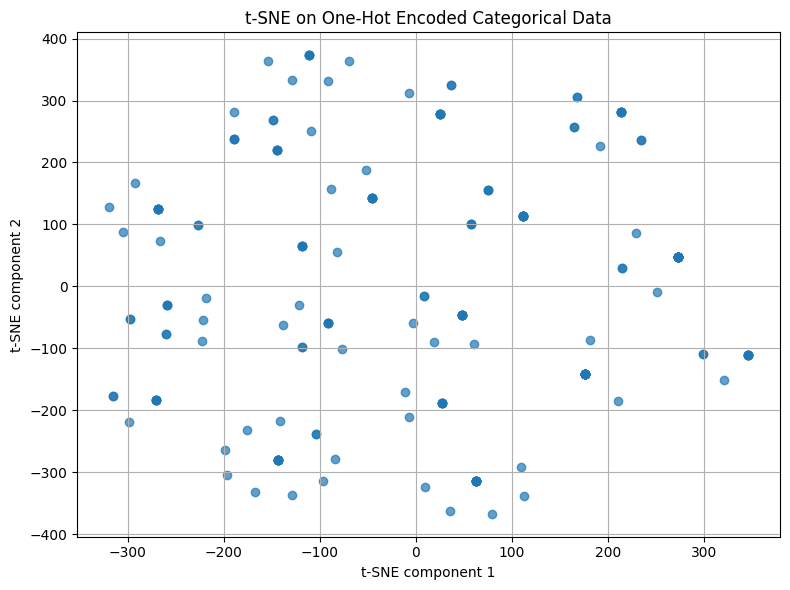

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Assume 'encoded_data' exists from the previous one-hot encoding step

# Apply t-SNE to the one-hot encoded data
tsne = TSNE(n_components=2, random_state=42)
tsne_results_cat = tsne.fit_transform(encoded_data)

# Scatter plot of the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_cat[:, 0], tsne_results_cat[:, 1], alpha=0.7)
plt.title('t-SNE on One-Hot Encoded Categorical Data')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## Hierarchical clustering

**Leaves**: Each leaf at the bottom of the dendrogram represents one sample from your dataset.

**Branches**: The branches connect the samples and groups of samples. The height of the branch represents the distance (dissimilarity) between the clusters being merged.

**Height of Merges**: Taller branches indicate that the clusters being merged are more dissimilar, while shorter branches indicate more similar clusters.

**Clusters**: By drawing a horizontal line across the dendrogram at a certain distance, you can define clusters. All samples below that line that are connected by branches form a cluster.

* In the context of your one-hot encoded categorical data (species, tissue, condition), the dendrogram shows how samples are grouped based on their combinations of these categorical features.

* Samples with the same or very similar combinations of categories will be closer together in the dendrogram and merge at lower distances.

* The structure of the dendrogram reflects the relationships and similarities between the different combinations of species, tissue, and condition present in your synthetic dataset.

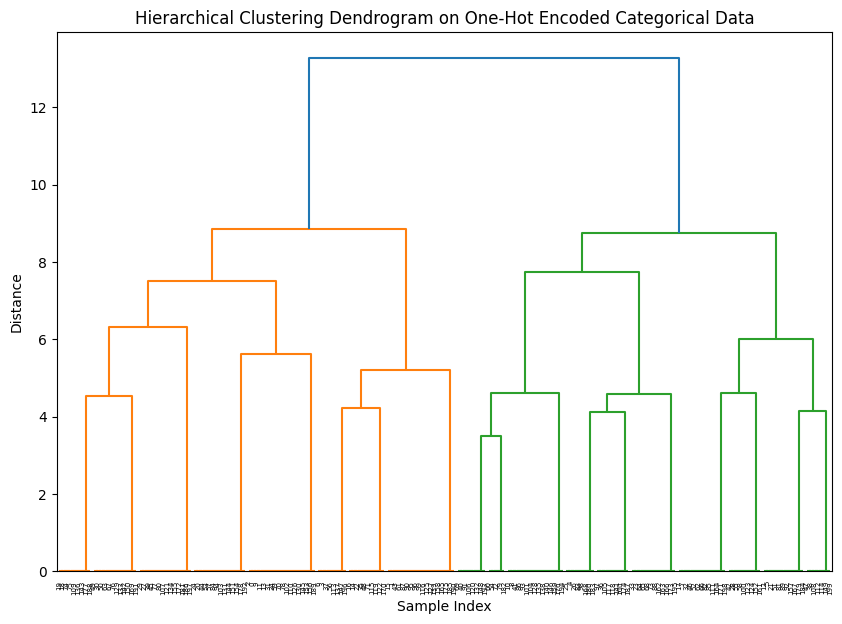

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# Assume 'encoded_data' exists from the previous one-hot encoding step

# Perform hierarchical clustering
# Using 'ward' linkage and 'euclidean' distance is common for this type of data
linked = linkage(encoded_data, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram on One-Hot Encoded Categorical Data')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

## Heatmaps

Heatmaps are a great way to visualize data and clustering

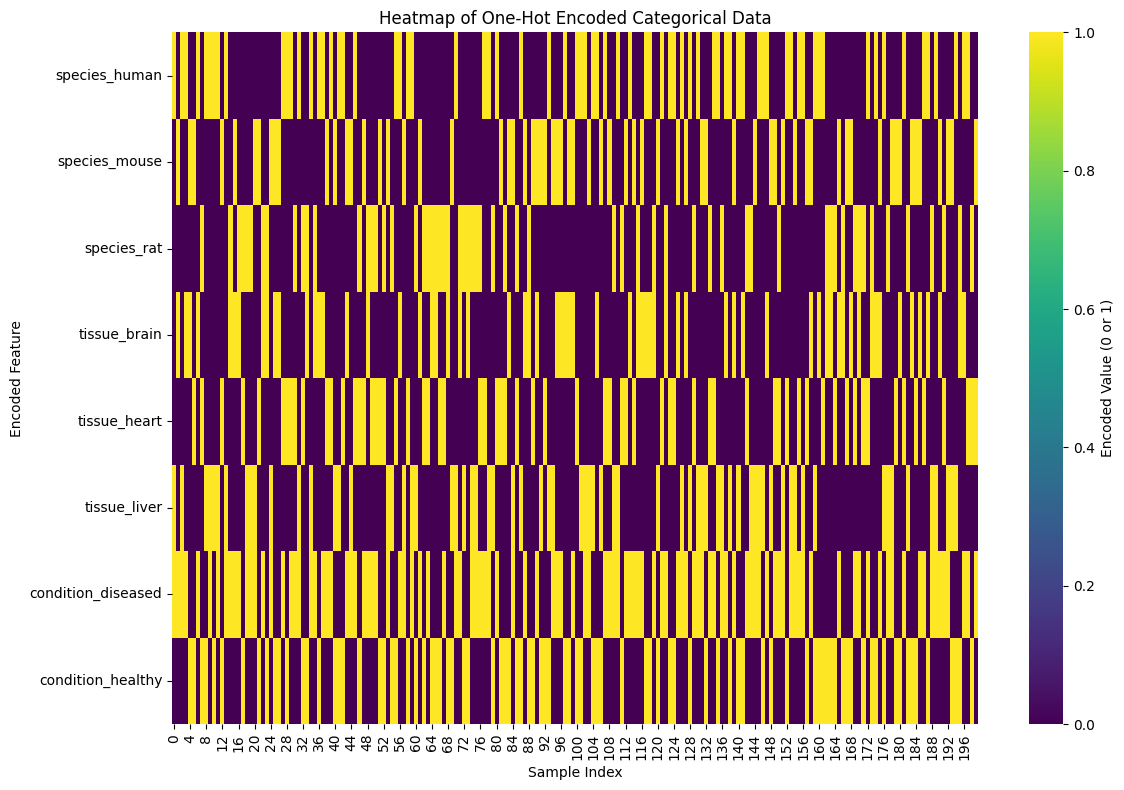

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume 'encoded_df' exists from the previous one-hot encoding step

plt.figure(figsize=(12, 8)) # Adjust figure size as needed
sns.heatmap(encoded_df.T, cmap='viridis', cbar_kws={'label': 'Encoded Value (0 or 1)'}) # Transpose for features on y-axis
plt.title('Heatmap of One-Hot Encoded Categorical Data')
plt.xlabel('Sample Index')
plt.ylabel('Encoded Feature')
plt.tight_layout()
plt.show()

### Reference

*   How to Use t-SNE Effectively: [https://distill.pub/2016/misread-tsne/](https://distill.pub/2016/misread-tsne/)


*   Deconvolution of monocyte responses in inflammatory bowel disease reveals an IL-1 cytokine network that regulates IL-23 in genetic and acquired IL-10 resistance. D Aschenbrenner, M Quaranta, S Banerjee, N Ilott, J Jansen, B Steere, et al. Gut 10, 2021.


## Appendix

Here are the key equations involved in Principal Component Analysis (PCA):

**1. Data Centering**

Before applying PCA, the data is typically centered by subtracting the mean of each feature.

$\mathbf{X}_{centered} = \mathbf{X} - \mathbf{\mu}$

where:
- $\mathbf{X}$ is the original data matrix (samples × features)
- $\mathbf{\mu}$ is the vector of means for each feature
- $\mathbf{X}_{centered}$ is the centered data matrix

**Equations**

$PC_{1} = \phi_{1} * X + \phi_{2} * Y + \phi_{3} * Z + ....$

**Covariance Matrix**

The covariance matrix captures the relationships between different features.

$\mathbf{\Sigma} = \frac{1}{n-1} \mathbf{X}_{centered}^T \mathbf{X}_{centered}$

where:
- $\mathbf{\Sigma}$ is the covariance matrix
- $n$ is the number of samples
- $\mathbf{X}_{centered}^T$ is the transpose of the centered data matrix

**Eigenvalue Decomposition**

The core of PCA involves finding the eigenvalues and eigenvectors of the covariance matrix.

$\mathbf{\Sigma} \mathbf{v}_i = \lambda_i \mathbf{v}_i$

where:
- $\mathbf{\Sigma}$ is the covariance matrix
- $\mathbf{v}_i$ is the $i$-th eigenvector
- $\lambda_i$ is the $i$-th eigenvalue

The eigenvectors represent the principal components (the directions of maximum variance), and the eigenvalues represent the amount of variance explained by each principal component.

**Selecting Principal Components**

Principal components are typically ordered by their eigenvalues in descending order. You select the top $k$ eigenvectors corresponding to the largest eigenvalues to form the projection matrix.

$\mathbf{W} = [\mathbf{v}_1, \mathbf{v}_2, ..., \mathbf{v}_k]$

where:
- $\mathbf{W}$ is the projection matrix (features × k)
- $\mathbf{v}_i$ are the selected eigenvectors (principal components)

**5. Projecting Data onto New Space**

Finally, the centered data is projected onto the new lower-dimensional space defined by the selected principal components.

$\mathbf{Y} = \mathbf{X}_{centered} \mathbf{W}$

where:
- $\mathbf{Y}$ is the transformed data in the lower-dimensional space (samples × k)
- $\mathbf{X}_{centered}$ is the centered data matrix
- $\mathbf{W}$ is the projection matrix

These equations outline the mathematical process of transforming data into a new coordinate system defined by the principal components, ordered by the amount of variance they capture.

## Introduction to t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique primarily used for visualizing high-dimensional datasets. Unlike linear methods like PCA, t-SNE is particularly good at preserving the local structure of the data, making it effective for revealing clusters and relationships between data points in a lower-dimensional space (typically 2D or 3D).

Here are some key aspects of t-SNE:

*   **Focus on Local Structure:** t-SNE aims to map high-dimensional data points to a lower-dimensional space such that the pairwise similarities between points are preserved. It does this by modeling the probability distribution of pairwise similarities in both the high-dimensional and low-dimensional spaces and minimizing the difference between these distributions. The "t-distributed" part comes from using a heavy-tailed Student's t-distribution in the low-dimensional space to model similarities, which helps to alleviate the "crowding problem" where points from different clusters can be squeezed together.

*   **Non-linear:** t-SNE is a non-linear technique, meaning it can capture complex, non-linear relationships in the data that linear methods might miss. This makes it suitable for visualizing data with intricate structures, such as the manifold-like data often seen in single-cell genomics or image datasets.

*   **Visualization Tool:** While t-SNE can be used for dimensionality reduction, its primary strength lies in creating insightful visualizations. The plots it generates can reveal clusters, outliers, and the overall shape of the data distribution in a way that is often more interpretable than linear methods for complex data.

*   **Perplexity Parameter:** A key parameter in t-SNE is `perplexity`. This parameter can be thought of as a knob that tunes the balance between focusing on local and global structure. It's related to the number of nearest neighbors considered for each point. Choosing an appropriate perplexity is important for obtaining a meaningful visualization, and it often requires some experimentation.

*   **Interpretation Caution:** It's important to interpret t-SNE plots with caution. The distances between clusters in a t-SNE plot may not accurately reflect the true distances in the high-dimensional space. t-SNE is excellent at showing *whether* clusters exist and how points are related within those clusters, but the relative spacing and size of the clusters themselves should not be over-interpreted as precise measures of distance or density in the original data.

In summary, t-SNE is a powerful visualization tool for exploring the structure of high-dimensional data, especially when that structure is non-linear and involves distinct clusters.